In [1]:
import pandas as pd
import numpy as np
import obonet
import networkx as nx

# Load the data generated from the R code

In [2]:
bp_db = pd.read_csv("../data/annotations-gene-GO.csv")
bp_db = bp_db.drop_duplicates()
bp_db.head()

,ENSEMBL,GO
0,ENSG00000000003,GO:0039532
1,ENSG00000000003,GO:0043123
2,ENSG00000000003,GO:1901223
3,ENSG00000000005,GO:0001886
4,ENSG00000000005,GO:0001937


In [3]:
bp_db.describe()

,ENSEMBL,GO
count,132627,132627
unique,17599,12305
top,ENSG00000148400,GO:0006357
freq,158,1426


In [4]:
counts1 = pd.read_csv("../data/counts1.csv", index_col=0)
counts1.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSGR0000167393,ENSGR0000169084,ENSGR0000169093,ENSGR0000178605,ENSGR0000182378,ENSGR0000185291,ENSGR0000198223,ENSGR0000214717,ENSGR0000223511,ENSGR0000223773
089357B,14,7,103,241,72,2057,30,60,207,367,...,1,0,0,0,0,0,0,0,0,0
089366A,11,2,194,511,110,3325,36,111,186,530,...,0,0,0,0,0,0,1,0,0,1
089412B,8,0,312,450,106,3751,45,160,325,653,...,0,0,0,0,0,0,1,0,0,0
089425B,9,0,135,496,133,2758,26,93,182,620,...,0,0,0,0,0,0,0,0,0,0
089687A,4,0,89,267,49,2181,24,75,122,263,...,0,0,0,0,0,0,1,0,0,0


In [5]:
pheno1 = pd.read_csv("../data/pheno1.csv", index_col=0)
pheno1.head()

,age,diagnosis,sex,lithium,condition
089357B,18,Control,F,0,Control
089366A,19,Control,F,0,Control
089412B,23,Control,F,0,Control
089425B,47,Control,F,0,Control
089687A,52,Control,F,0,Control


# Data Exploration Analysis

In [6]:
available_genes = set(bp_db.ENSEMBL)
("length of all_genes :", len(available_genes))

('length of all_genes :', 17600)

In [7]:
data_genes = set(counts1.columns)
("length of data_genes :", len(data_genes))

('length of data_genes :', 52645)

In [8]:
("Number of genes missing :", len(data_genes - available_genes))

('Number of genes missing :', 35046)

In [9]:
("Ratio of genes missing : {:.2f}%".format(len(data_genes - available_genes) / len(data_genes) * 100))

'Ratio of genes missing : 66.57%'

# Clean the GO annotations and the GO graph

## only keep GO annotations that are associated with the genes in the data

In [10]:
bp_db = bp_db[bp_db.ENSEMBL.isin(counts1.columns)]
bp_db.describe()

,ENSEMBL,GO
count,132627,132627
unique,17599,12305
top,ENSG00000148400,GO:0006357
freq,158,1426


In [11]:
bp_db_go = set(bp_db.GO)
bp_db_genes = set(bp_db.ENSEMBL)

## load GO graph

In [12]:
# Read the gene ontology
!wget http://purl.obolibrary.org/obo/go/go-basic.obo 
original_graph = obonet.read_obo('go-basic.obo')
!rm go-basic.obo

--2024-04-21 02:23:35--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 2606:4700:4400::ac40:96c5, 2606:4700:4400::6812:253b, 172.64.150.197, ...
Connecting to purl.obolibrary.org (purl.obolibrary.org)|2606:4700:4400::ac40:96c5|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2024-04-21 02:23:36--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 2600:9000:24db:f600:d:ff6c:c780:93a1, 2600:9000:24db:9800:d:ff6c:c780:93a1, 2600:9000:24db:ec00:d:ff6c:c780:93a1, ...
Connecting to current.geneontology.org (current.geneontology.org)|2600:9000:24db:f600:d:ff6c:c780:93a1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31245945 (30M) [text/obo]
Saving to: ‘go-basic.obo’

go-basic.obo        100%[===================>]  29.80M  10.2MB/s    in 2.9s    

2

## only keep the Biological Process (BP) subgraph

In [13]:
bp_node = "GO:0008150"
bp_graph_nodes = nx.ancestors(original_graph, bp_node)
bp_graph_nodes.add(bp_node)
bp_graph = original_graph.subgraph(bp_graph_nodes)
print("Number of nodes in the graph", len(bp_graph))

Number of nodes in the graph 27046


## filter the GO terms that are not in the graph

In [14]:
bp_db = bp_db[bp_db.GO.isin(bp_graph_nodes)]
bp_db.describe()

,ENSEMBL,GO
count,131767,131767
unique,17589,12101
top,ENSG00000148400,GO:0006357
freq,158,1426


##  remove the branch whose all descendants nodes are not in the list of GO terms

In [15]:
bp_db_nodes = set(bp_db.GO.unique())

leaves = [x for x in bp_graph_nodes if bp_graph.in_degree(x) == 0]
removes = []
while leaves:
    tmp_node = leaves.pop(0)
    if tmp_node not in bp_db_nodes:
        removes.append(tmp_node)
        leaves.extend(list(bp_graph.predecessors(tmp_node)))
len(removes)

7256

In [16]:
bp_graph = original_graph.subgraph(bp_graph_nodes - set(removes))
print("Number of nodes in the graph", len(bp_graph))

Number of nodes in the graph 19790


## for a genes, which connected to multiple GO terms in the same branch, only keep the GO term that is the closest to the leave 

In [17]:
go_genes_map = {}
for idx, row in bp_db.iterrows():
    go = row.GO
    gene = row.ENSEMBL
    if go not in go_genes_map:
        go_genes_map[go] = set()
    go_genes_map[go].add(gene)

leaves = [x for x in bp_graph_nodes if bp_graph.in_degree(x) == 0]

removes_terms = set()

def dfs(node):
    res = set()
    if bp_graph.in_degree(node) != 0:  # collect all the genes from the parents
        for parent in bp_graph.predecessors(node):
            res = res.union(dfs(parent))
    if node in go_genes_map: # compare and record the genes that already appears in the parents
        for gene in go_genes_map[node].intersection(res):
            removes_terms.add(tuple([node, gene]))
        res = res.union(go_genes_map[node])
    return res

_ = dfs(bp_node)

In [18]:
len(removes_terms)

23719

In [19]:
bp_db = bp_db[~bp_db.apply(lambda x: tuple([x.GO, x.ENSEMBL]) in removes_terms, axis=1)]
bp_db.describe()

,ENSEMBL,GO
count,108048,108048
unique,17589,11767
top,ENSG00000148400,GO:0045944
freq,126,1105


In [20]:
bp_db

,ENSEMBL,GO
0,ENSG00000000003,GO:0039532
1,ENSG00000000003,GO:0043123
2,ENSG00000000003,GO:1901223
3,ENSG00000000005,GO:0001886
4,ENSG00000000005,GO:0001937
...,...,...
182195,ENSG00000273079,GO:1904062
182196,ENSG00000273079,GO:2000463
182198,ENSG00000273079,GO:2001056
182250,ENSG00000273173,GO:0008150


## define a function that can remove the lowest level of the GO terms, and re-assign the genes to the parent GO term

In [21]:
def remove_lowest_level(graph, bp_df):
    _leaves = [x for x in graph.nodes if graph.in_degree(x) == 0]
    new_tuples = set()
    for _idx, _row in bp_df[bp_df.GO.isin(_leaves)].iterrows():
        _gene = _row.ENSEMBL
        _go = _row.GO
        for _parent in graph.successors(_go):
            new_tuples.add((_gene, _parent))
    new_df = pd.concat([bp_df[~bp_df.GO.isin(_leaves)], pd.DataFrame(new_tuples, columns=["ENSEMBL", "GO"])], ignore_index=True)
    new_graph = graph.subgraph(set(graph.nodes) - set(_leaves))
    return new_graph, new_df

sub_graph, sub_bp_db = remove_lowest_level(bp_graph, bp_db)

In [22]:
print("Number of nodes in the graph", len(sub_graph))
sub_bp_db.describe()

Number of nodes in the graph 12024


,ENSEMBL,GO
count,146247,146247
unique,17589,8995
top,ENSG00000148400,GO:0045944
freq,200,1165


In [23]:
def remove_lowest_level(graph, bp_df):
    _leaves = [x for x in graph.nodes if graph.in_degree(x) == 0]
    new_tuples = set()
    for _idx, _row in bp_df[bp_df.GO.isin(_leaves)].iterrows():
        _gene = _row.ENSEMBL
        _go = _row.GO
        for _parent in graph.successors(_go):
            new_tuples.add((_gene, _parent))
    new_df = pd.concat([bp_df[~bp_df.GO.isin(_leaves)], pd.DataFrame(new_tuples, columns=["ENSEMBL", "GO"])], ignore_index=True)
    new_graph = graph.subgraph(set(graph.nodes) - set(_leaves))
    return new_graph, new_df

sub_graph_2, sub_bp_db_2 = remove_lowest_level(sub_graph, sub_bp_db)

In [24]:
print("Number of nodes in the graph", len(sub_graph_2))
sub_bp_db_2.describe()

Number of nodes in the graph 7302


,ENSEMBL,GO
count,190962,190962
unique,17589,6129
top,ENSG00000148400,GO:0045944
freq,280,1232


## write the GO annotations and the GO graph to a file

In [25]:
def write_gml(graph, filename):
    tmp_graph = nx.Graph()
    tmp_graph.add_nodes_from(graph.nodes())
    tmp_graph.add_edges_from(graph.edges())
    nx.write_gml(tmp_graph, "../data/" + filename + ".gml")

bp_db.reset_index(drop=True, inplace=True)
bp_db.to_csv("../data/GOannotations_kept.csv")
write_gml(bp_graph, "bp_graph")

## get the degree and level info of the GO terms

In [26]:
in_d = [x[1] for x in bp_graph.in_degree()]
out_d = [x[1] for x in bp_graph.out_degree()]
levels = [nx.shortest_path_length(bp_graph, x, bp_node) for x in bp_graph.nodes]
go_nodes = list(bp_graph.nodes)
dfInfoGraph = pd.DataFrame({"root": levels, "d+": out_d, "d-": in_d}, index=go_nodes)
dfInfoGraph.head()

,root,d+,d-
GO:1904355,6,3,0
GO:0071243,4,2,3
GO:0075201,4,1,1
GO:0007026,5,5,0
GO:0150070,5,1,1


In [27]:
dfInfoGraph.describe()

,root,d+,d-
count,19790.000000,19790.000000,19790.000000
mean,4.810258,2.231733,2.231733
std,1.338441,1.011113,4.840105
min,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000
50%,5.000000,2.000000,1.000000
75%,6.000000,3.000000,3.000000
max,11.000000,9.000000,163.000000


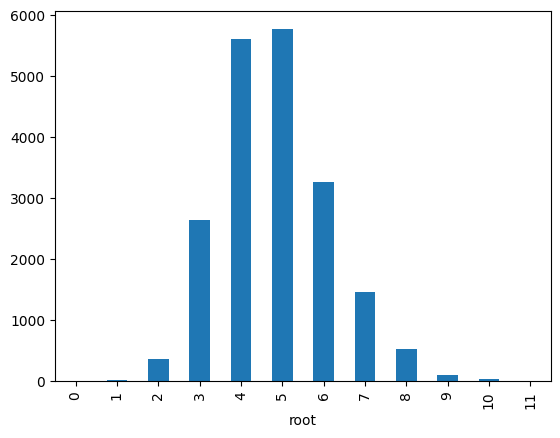

In [28]:
import matplotlib.pyplot as plt

dfInfoGraph.groupby("root").size().plot(kind='bar')
plt.show()

In [29]:
dfInfoGraph.to_csv("../data/go_to_level.csv")

## Convert the names of the nodes into integer

In [30]:
bp_db_go = sorted(set(bp_db['GO']).union(set(bp_graph.nodes)))
len(bp_db_go)

19790

In [31]:
import json

map_int_go = {i: go for i, go in enumerate(bp_db_go)}
with open('../data/map_int_go.txt', 'w') as f:
    json.dump(map_int_go, f, indent=2)

## split the annotation data and no annotation data

In [32]:
# bp_db_genes = set(bp_db.ENSEMBL)
# counts1.drop(columns=[x for x in counts1.columns if x not in bp_db_genes]).to_csv("../data/counts1_no_annotations.csv")
# counts1.drop(columns=[x for x in counts1.columns if x in bp_db_genes]).to_csv("../data/counts1_annotations.csv")